In [75]:
import numpy as np
from plotnine import *
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pandas import DataFrame
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample
from sklearn.datasets import make_gaussian_quantiles

# AdaBoost Implementation

In [76]:
class BoostedDecisionTreeClassifier:
    def __init__(self):
        self.D, self.err, self.w, self.hs = None, None, None, None
    
    def fit(self, X, y, iters):
        m = len(y)
        D, err, w, hs = np.zeros((iters+1, m)), np.zeros(iters), np.zeros(m), []
        D[0,:] = 1/m
        
        for t in range(iters):
            # Invoke base learner 
            h = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2).fit(X, y, sample_weight=D[t,:])
            y_pred = h.predict(X)
            
            # Calculate weight of current learner
            err[t] = D[t, y != y_pred].sum()
            w[t] = np.log((1 - err[t]) / err[t]) / 2
            
            # Update sample weight distribution
            D_next = D[t,:] * np.exp(- w[t] * y * y_pred)
            D_next /= D_next.sum()
            
            D[t+1,:] = D_next
            hs.append(h)
        
        self.D, self.err, self.w, self.hs = D, err, w, hs
        return self
    
    def predict(self, X):
        if self.hs is None:
            raise ValueError('Cannot perform `predict` operation before fitting a model')
        return np.sign(np.array([self.w[t] * h.predict(X) for t, h in enumerate(self.hs)]).sum(axis=0))

# AdaBoost Example - 2D 

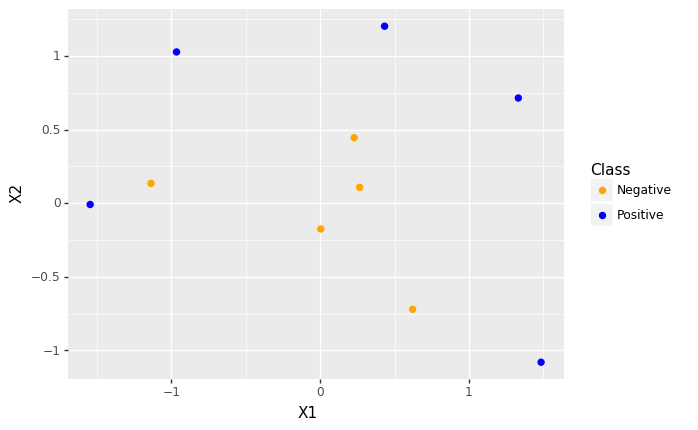

<ggplot: (192257590620)>

In [77]:
# We begin with a data simulation scenario where the data-points are a 2D Gaussian with the inner part
# belongs to the one class and the outer part to the other.
np.random.seed(10)
X, y = make_gaussian_quantiles(n_samples=10, n_features=2, n_classes=2) 

(ggplot(DataFrame({'X1' :X[:,0], 'X2': X[:,1],'class':y==1}), aes(x='X1', y='X2', color='class')) +
 geom_point(size=2) + 
 labs(title="", color="Class") + 
 scale_color_manual(values=["orange", "blue"], labels=["Negative", "Positive"]))


In [78]:
def get_classification_groups(y, y_pred):
    y, y_pred = y.astype(bool), y_pred.astype(bool)
    
    group = np.repeat('  ', len(y))
    group[np.where(y  &  y_pred)] = "TP"
    group[np.where(y  & ~y_pred)] = "FN"
    group[np.where(~y &  y_pred)] = "FP"
    group[np.where(~y & ~y_pred)] = "TN"
    return group, np.isin(group, ["TP", "TN"])
    

def fit(x, y, iters):
    model = BoostedDecisionTreeClassifier().fit(X, y, iters)
    y_pred = model.predict(X)
    
    weights = model.D[-1,:]
    bins = np.around(np.linspace(weights.min(), weights.max(), 5), 4)
    centers = (bins[1:]+bins[:-1])/2
    weights = bins[np.digitize(weights, centers)]
    # for i in np.linspace(0.9, 0 , 10):
    #     weights[(weights>i) & (weights <i + 0.1)] = i + 0.05
    # weights = np.around(weights, decimals=2)
    
    group, correct_class = get_classification_groups(y, y_pred)
    df = DataFrame({'X1':x[:,0], 'X2':x[:, 1], 'class':y==1, 'pred': y_pred==1, '~Weight': weights,
                    'correct': correct_class, 'group': group, 'set': 'Train', 'iters': 'T = ' + str(iters)})
    return model , df
  

def space_partitioning(model, x):
    # Later, for visualization, we would like to see the different partitions the classification tree
    # created. For that we create a 2D grid uniformly spread over R^2 of points. There points are to 
    # be classified by the fitted tree, and will be used to show the decision boundaries
    margin = 1.5
    x1_grid, x2_grid = np.meshgrid(np.linspace(x[:, 0].min() - margin, x[:, 0].max() + margin, 100),
                                   np.linspace(x[:, 1].min() - margin, x[:, 1].max() + margin, 100))
    partitioning = np.c_[x1_grid.ravel(), x2_grid.ravel()]
    partitioning_class = model.predict(partitioning) == 1

    return DataFrame({'X1': partitioning[:, 0], 'X2': partitioning[:, 1], 'class': partitioning_class,
                      'pred': [None]*len(partitioning), 'correct': [None]*len(partitioning), 
                      'group': [None]*len(partitioning), 'set': 'Partition', 'iters': 'T = %d' % len(model.hs), 
                      '~Weight':[None] * len(partitioning)})

c:\users\gilad\documents\masters\iml ta\labs\venv\lib\site-packages\plotnine\scales\scale_size.py:50: PlotnineWarning: Using alpha for a discrete variable is not advised.
  PlotnineWarning


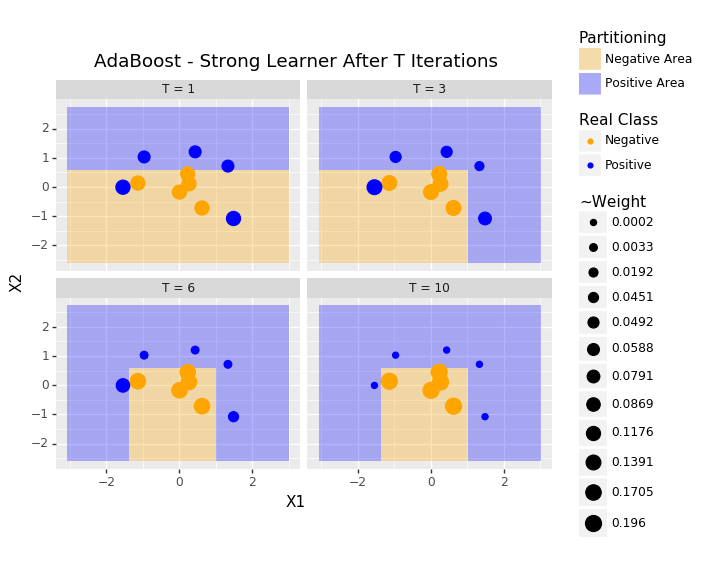

<ggplot: (-9223371844604634087)>

In [86]:
df = []
for t in [1, 3, 6, 10]:
    model, d = fit(X, y, t)
    df.extend([d, space_partitioning(model, X)])
df = pd.concat(df)

df['iters'] = pd.Categorical(df['iters'], 
                            ordered=True,
                            categories=["T = " + str(T) for T in [1, 3, 6, 10]])

(ggplot(df[df.set == "Train"], aes(x="X1", y="X2")) +
 geom_tile(df[df.set == "Partition"], aes(fill="class"), alpha=.3) + 
 geom_point(aes(color='class', size = '~Weight')) +
 labs(title="AdaBoost - Strong Learner After T Iterations", color="Real Class", fill="Partitioning") + 
 scale_fill_manual(values=["orange", "blue"],  labels=["Negative Area", "Positive Area"]) + 
 scale_color_manual(values=["orange", "blue"],  labels=["Negative", "Positive"])+ 
 facet_wrap("iters"))

# Training AdaBoost and Bootstrap

In [80]:
mnist = tf.keras.datasets.mnist

In [81]:
def get_2_labels(first_digit, second_digit):
    (x_train, y_train),(x_test, y_test) = mnist.load_data()

    x_train = (x_train / 255.0 * 2 - 1).reshape(x_train.shape[0], -1)
    x_test = (x_test / 255.0 * 2 - 1).reshape(x_test.shape[0], -1)
    y_train = np.squeeze(y_train)
    y_test = np.squeeze(y_test)

    train_images = np.logical_or((y_train == first_digit), (y_train == second_digit))
    test_images = np.logical_or((y_test == first_digit), (y_test == second_digit))
    return x_train[train_images,:], y_train[train_images], x_test[test_images,:], y_test[test_images]


first_label = 8
second_label = 9
x_train, yy_train, x_test, yy_test = get_2_labels(first_label, second_label)

###########################
# change classes to -1,1
###########################
y_train = np.ones(shape = len(yy_train))
y_train[yy_train == first_label] = -1
y_test=np.ones(shape = len(yy_test))
y_test[yy_test == first_label] = -1


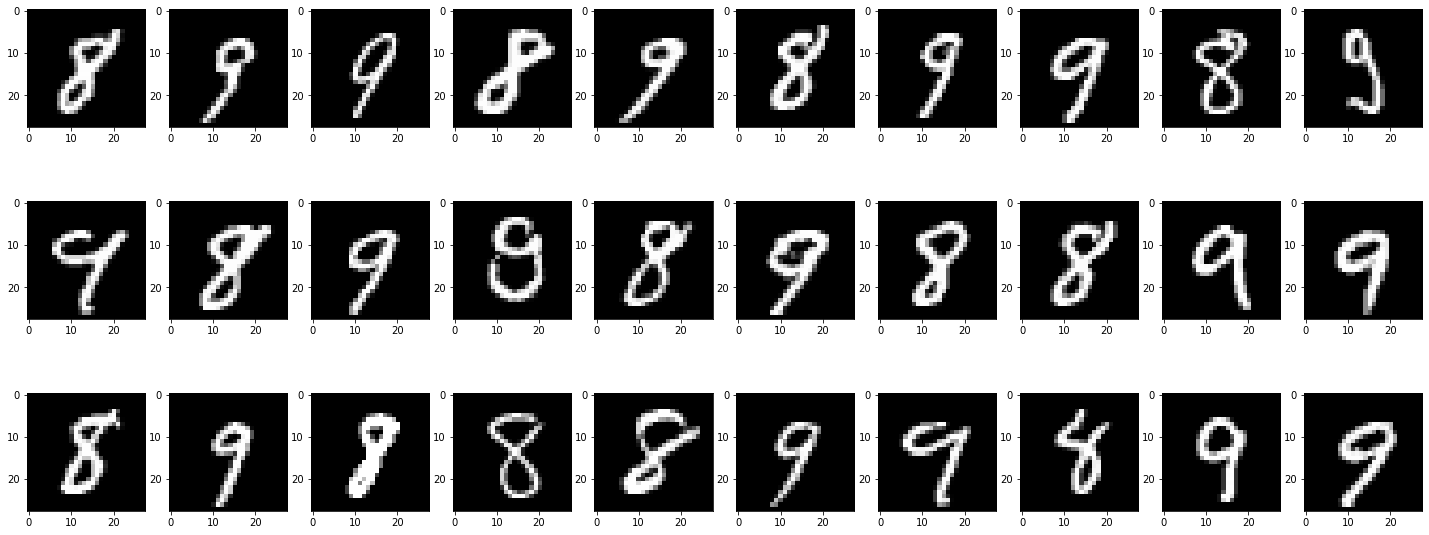

In [82]:
plt.figure(figsize=(25,10))
for i in range(1, 31):
    ax = plt.subplot(3, 10, i) 
    ax.imshow(x_train[i].reshape(28,28), cmap=plt.cm.gray)

In [83]:
iterations = [1, 5, 10, 20, 35, 50]  # number of weak learners

def train_adaboost():
    train_errors = []
    test_errors = []
    train_var = []
    test_var = []
    
    max_interations = iterations[-1]
    fit(x_train, y_train, max_interations)
    
    for T in iterations: 
        train_pred = predict(x_train, T)
        test_pred = predict(x_test, T)
        test_errors.append(1 - np.mean(test_pred == y_test))
        train_errors.append(1 - np.mean(train_pred == y_train))
        train_var.append(train_pred.var())
        test_var.append(test_pred.var())

    return train_errors, test_errors, train_var, test_var



def train_bootstrap():
    all_indexes = np.arange(len(x_train))
    train_errors = []
    test_errors = []
    train_var = []
    test_var = []
    
    max_interations = iterations[-1]
    stumps = np.zeros(shape = max_interations, dtype=object)
        
    for t in range(max_interations):
        # resample new dataset(with replacement)
        indexes = resample(all_indexes, replace = True, n_samples = len(x_train)//100)

        new_x_train, new_y_train = x_train[indexes], y_train[indexes]

        stump = DecisionTreeClassifier(max_depth=1)
        stump.fit(new_x_train, new_y_train)
        stumps[t] = stump
    
    for T in iterations:
        # predicting with weak leaners (stumps)
        train_pred = np.sign(np.sum([stumps[t].predict(x_train) for t in range(T)], axis = 0))
        train_errors.append (1 - np.mean(train_pred == y_train))
        train_var.append(train_pred.var())
        
        test_pred = np.sign(np.sum([stumps[t].predict(x_test) for t in range(T)], axis = 0))
        test_errors.append (1 - np.mean(test_pred == y_test))
        test_var.append(test_pred.var())
    
    return train_errors, test_errors, train_var, test_var

In [84]:
%%time

ada_train_error, ada_test_error, ada_train_var, ada_test_var = train_adaboost()
boot_train_error, boot_test_error, boot_train_var, boot_test_var = train_bootstrap()

ValueError: Number of labels=11800 does not match number of samples=10

In [85]:
df = DataFrame({'T':iterations, 'error':ada_test_error, 'class':'Boosting', 'set':'test', 'line':'solid'})
df = pd.concat([df,DataFrame({'T':iterations, 'error':boot_test_error, 'class':'Bagging', 'set':'test', 'line':'solid'})])
df = pd.concat([df,DataFrame({'T':iterations, 'error': ada_train_error, 'class':'Boosting', 'set':'train', 'line':'dashed'})])
df = pd.concat([df,DataFrame({'T':iterations, 'error': boot_train_error, 'class':'Bagging', 'set':'train', 'line':'dashed'})])


(ggplot() +
 geom_line(aes(x='T', y='error', color= 'class', linetype = 'line'), data=df[df.set=='test'],  size=0.5) +
  geom_line(aes(x='T', y='error', color= 'class', linetype = 'line'), data=df[df.set=='train'],  size=0.5) +
 scale_linetype_manual(values = ['solid', 'dashed'] , labels = ['test', 'train'])+
 labs(x="T - iterations", y="Error", title="Train/Test Error VS Number Of Iterations", color="Algorithm"))

NameError: name 'ada_test_error' is not defined

In [ ]:
df = DataFrame({'T':iterations, 'variance':ada_test_var, 'class':'Boosting', 'set':'test', 'line':'solid'})
df = pd.concat([df,DataFrame({'T':iterations, 'variance': boot_test_var, 'class':'Bagging', 'set':'test', 'line':'solid'})])
df = pd.concat([df,DataFrame({'T':iterations, 'variance': ada_train_var, 'class':'Boosting', 'set':'train', 'line':'dashed'})])
df = pd.concat([df,DataFrame({'T':iterations, 'variance': boot_train_var, 'class':'Bagging', 'set':'train', 'line':'dashed'})])


(ggplot() +
 geom_line(aes(x='T', y='variance', color= 'class', linetype = 'line'), data=df[df.set=='test'],  size=0.5) +
  geom_line(aes(x='T', y='variance', color= 'class', linetype = 'line'), data=df[df.set=='train'],  size=0.5) +
 scale_linetype_manual(values = ['solid', 'dashed'] , labels = ['test', 'train'])+
 labs(x="T - iterations", y="Variance", title="Train/Test Variance VS Number Of Iterations", color="Algorithm"))

In [ ]:
def diff (list1, list2):
    return [a-b for a,b in zip(list1,list2)]

In [ ]:
df = DataFrame({'T':iterations, 'bias':diff(ada_test_error,ada_test_var), 'class':'Boosting', 'set':'test', 'line':'solid'})
df = pd.concat([df,DataFrame({'T':iterations, 'bias': diff(boot_test_error,boot_test_var), 'class':'Bagging', 'set':'test', 'line':'solid'})])
df = pd.concat([df,DataFrame({'T':iterations, 'bias': diff(ada_train_error,ada_train_var), 'class':'Boosting', 'set':'train', 'line':'dashed'})])
df = pd.concat([df,DataFrame({'T':iterations, 'bias': diff(boot_train_error,boot_train_var), 'class':'Bagging', 'set':'train', 'line':'dashed'})])


(ggplot() +
 geom_line(aes(x='T', y='bias', color= 'class', linetype = 'line'), data=df[df.set=='test'],  size=0.5) +
  geom_line(aes(x='T', y='bias', color= 'class', linetype = 'line'), data=df[df.set=='train'],  size=0.5) +
 scale_linetype_manual(values = ['solid', 'dashed'] , labels = ['test', 'train'])+
 labs(x="T - iterations", y="Bias", title="Train/Test Bias VS Number Of Iterations", color="Algorithm"))